In [1]:
import numpy as np
from utils.database_repository import DataRepository
from utils.objects import *
import matplotlib.pyplot as plt
from collections import defaultdict
import numpy as np

In [2]:
repository = DataRepository()

Connected to MySQL Server version  5.7.39-42-log


In [3]:
dut_os = "Win32NT"
profiler_name = "IntelPowerGadget"

# dut_name = "PowerKomplett" 
# version = 3

# dut_name = "Surface4Pro"
# version = 6

dut_name = "SurfaceBook"
version = 3


test_case_name = "IdleCase"
# test_case_name = "DiningPhilosophers"

min_temp = 0
max_temp = 200

min_battery = 1
max_battery = 100

between = 0
duration = 1


language = "CSharp"
env = "PROD"

limit = 200

In [4]:
energy_profiler = EnergyProfiler(profiler_name, repository)

energy_profiler.id, energy_profiler.energy_profiler_name


(1, 'IntelPowerGadget')

In [5]:
dut = Dut(dut_name, dut_os, repository)

dut.id, dut.dut_name, dut.dut_os

(8, 'SurfaceBook', 'Win32NT')

In [6]:
config = Configuration(min_temp, max_temp, min_battery, max_battery, duration, between, version, repository, env)

config.id, config.min_battery, config.max_battery, config.min_temp, config.max_temp, config.version, config.env, config.duration, config.between

(19, 1, 100, 0, 200, 3, 'PROD', 1, 0)

In [7]:
test_case = TestCase(test_case_name, repository)
test_case.id, test_case.test_case_name

(3, 'IdleCase')

In [10]:
experiment = Experiment(config.id, dut.id, test_case.id, language, repository, 200)
len(experiment.experiments), experiment.config_id, experiment.dut_id, experiment.language, experiment.test_case_id, experiment.count


JSONDecodeError: Unterminated string starting at: line 1 column 49990 (char 49989)

In [ ]:
repository.close()

In [ ]:
temp_experiment = experiment.experiments[0]

temp_experiment.end_time, temp_experiment.start_time, temp_experiment.runs, temp_experiment.iteration, temp_experiment.duration

(datetime.datetime(2022, 10, 28, 12, 42, 51, 54675),
 datetime.datetime(2022, 10, 28, 12, 41, 50, 952072),
 2,
 4,
 60045)

In [ ]:
[x.value for x in temp_experiment.start_temperature.data], [x.value for x in temp_experiment.stop_temperature.data]

([Decimal('38'), Decimal('41')], [Decimal('31'), Decimal('31')])

In [ ]:
[x.value for x in temp_experiment.start_battery.data], [x.value for x in temp_experiment.stop_battery.data]

([Decimal('57')], [Decimal('58')])

In [ ]:
durations = [x.duration / x.runs for x in experiment.experiments]
dram_avg = [x.CumulativeDramEnergyInJoules for x in experiment.experiments]
gt_power_avg = [x.CumulativeGtEnergyInJoules for x in experiment.experiments]
ai_power_avg = [x.CumulativeIaEnergyInJoules for x in experiment.experiments]
processor_power_avg = [x.CumulativeProcessorEnergyInJoules for x in experiment.experiments]

In [ ]:
dram_avg

[30594788,
 29881348,
 30260436,
 35434020,
 29799132,
 29972412,
 29881714,
 29934144,
 30000854,
 29851380,
 29927308,
 29920288,
 29938538,
 29966676,
 30006652,
 30004272,
 31123352,
 29978516,
 29904480,
 29925598,
 30809020,
 30380616,
 30395020,
 34762144,
 29976624,
 31257324,
 29955504,
 29946594,
 29937684,
 30700988,
 30372008,
 30637572,
 36137816,
 30290528,
 30994934,
 35204040,
 29985352,
 29972596,
 30030640,
 30604432,
 29971008,
 29998656,
 31980530,
 29890198,
 29894592,
 30276488,
 30197328,
 29979126,
 30048156,
 30115906,
 29976318,
 29925720,
 29964660,
 31329102,
 29942748,
 29968506,
 29962402,
 30210510,
 30289428,
 30406982,
 35360108,
 29872132,
 30029602,
 30110656,
 29961244,
 30078796,
 30030152,
 30048096,
 30139588,
 30049132,
 31301024,
 29965516,
 29997560,
 30282776,
 30825012,
 30339784,
 31044006,
 35999756,
 30691406,
 30633544,
 30565430,
 35724976]

In [ ]:
def add_avg_and_std(values, dict, name, i):
    dict[i]["avg_" + name] = sum(values) / len(values)  
    dict[i]["std_" + name] = np.std(values) 
    dict[i]["len_" + name] = len(values) 

In [ ]:
def plot_for_key(values_to_plot, key, y_max):
    plt.ylim(0,y_max)
    x = [v for v in values_to_plot]
    y = [values_to_plot[v]["avg_" + key] for v in values_to_plot]
    e = [values_to_plot[v]["std_" + key] for v in values_to_plot]
    
    counts = [values_to_plot[v]["len_" + key] for v in values_to_plot]
    
    print(f"The count: {counts}")

    plt.errorbar(x, y, e, linestyle='None', marker='.')

In [ ]:
groups = defaultdict(list)
values = defaultdict(dict)

for obj in experiment.experiments:
    groups[obj.iteration].append(obj)

tuples_to_plot = []

for g in groups:
    if not g in values:
        values[g] = {}
    
    durations = [x.duration / x.runs for x in groups[g]]
    dram_avg = [x.AverageDramPowerInWatt for x in groups[g]]
    gt_power_avg = [x.CumulativeGtEnergyInMwh for x in groups[g]]
    ai_power_avg = [x.AverageIaPowerInWatt for x in groups[g]]
    processor_power_avg = [x.AverageProcessorPowerWatt for x in groups[g]]
    
    # dram_avg = [x.CumulativeDramEnergyInJoules for x in groups[g]]
    # gt_power_avg = [x.CumulativeGtEnergyInJoules for x in groups[g]]
    # ai_power_avg = [x.CumulativeIaEnergyInJoules for x in groups[g]]
    # processor_power_avg = [x.CumulativeProcessorEnergyInJoules for x in groups[g]]
    
    
    add_avg_and_std(durations, values, "duration", g)
    add_avg_and_std(dram_avg, values, "dram", g)
    add_avg_and_std(gt_power_avg, values, "gt", g)
    add_avg_and_std(ai_power_avg, values, "ai", g)
    add_avg_and_std(processor_power_avg, values, "processor", g)



The count: [6, 7, 7, 7, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 1, 1, 1, 1, 1]


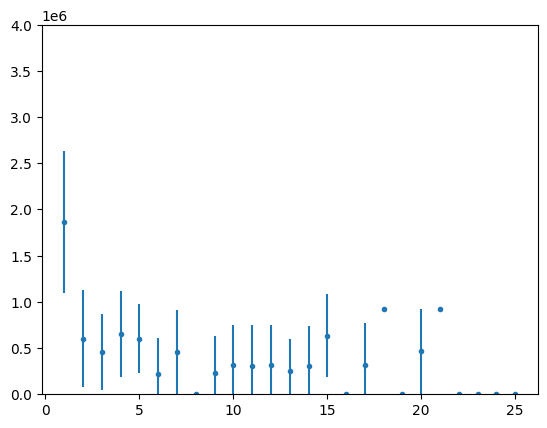

In [ ]:
plot_for_key(values, "processor", 4000000)


The count: [6, 7, 7, 7, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 1, 1, 1, 1, 1]


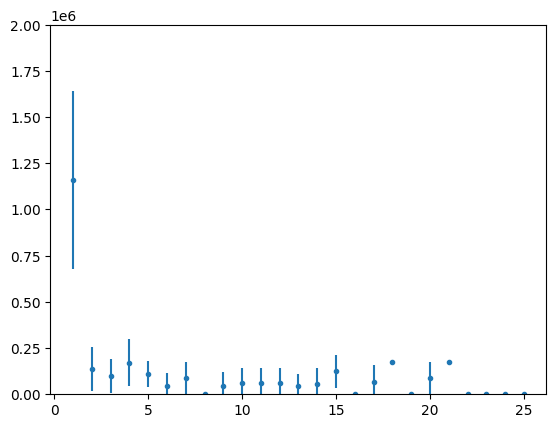

In [ ]:
plot_for_key(values, "ai", 2000000)


The count: [6, 7, 7, 7, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 1, 1, 1, 1, 1]


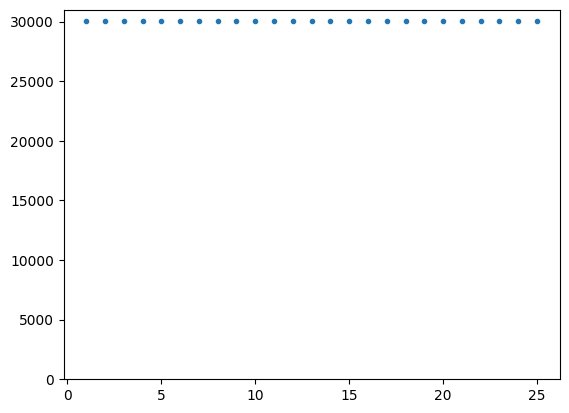

In [ ]:
plot_for_key(values, "duration", 31000)

The count: [6, 7, 7, 7, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 1, 1, 1, 1, 1]


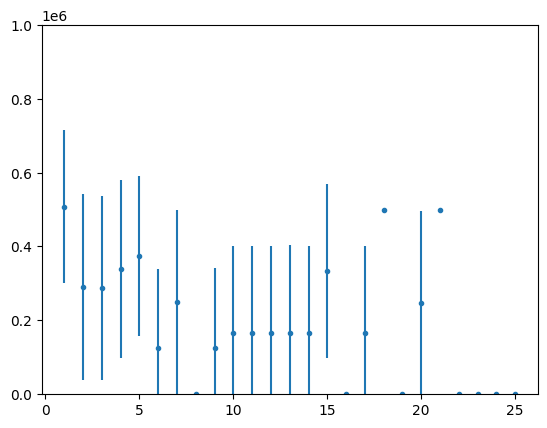

In [ ]:
plot_for_key(values, "dram", 1000000)

In [ ]:
# [x.value for x in temp_experiment.battery.data]
min_bucket = 0
max_bucket = 100
bucket_size = 5

last_value = 0

for i in range(min_bucket + bucket_size, max_bucket + 1, bucket_size):
    print(f"min: {last_value}, max: {i}, between: {((i - last_value) / 2) + last_value}")
    last_value = i



min: 0, max: 5, between: 2.5
min: 5, max: 10, between: 7.5
min: 10, max: 15, between: 12.5
min: 15, max: 20, between: 17.5
min: 20, max: 25, between: 22.5
min: 25, max: 30, between: 27.5
min: 30, max: 35, between: 32.5
min: 35, max: 40, between: 37.5
min: 40, max: 45, between: 42.5
min: 45, max: 50, between: 47.5
min: 50, max: 55, between: 52.5
min: 55, max: 60, between: 57.5
min: 60, max: 65, between: 62.5
min: 65, max: 70, between: 67.5
min: 70, max: 75, between: 72.5
min: 75, max: 80, between: 77.5
min: 80, max: 85, between: 82.5
min: 85, max: 90, between: 87.5
min: 90, max: 95, between: 92.5
min: 95, max: 100, between: 97.5
